In [1]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from pandas.plotting import lag_plot

import investpy as ipy #investing.com python library 

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
btc = ipy.get_crypto_historical_data(crypto='bitcoin', from_date='01/01/2012', to_date = '13/03/2021')

print(btc.head())

            Open  High  Low  Close  Volume Currency
Date                                               
2012-01-01   4.7   5.5  4.6    5.3  108509      USD
2012-01-02   5.3   5.5  4.8    5.2   69151      USD
2012-01-03   5.2   5.3  4.7    4.9  125170      USD
2012-01-04   4.9   5.7  4.8    5.6  131171      USD
2012-01-05   5.6   7.2  5.6    6.9  182328      USD


Text(0.5, 1.0, 'BTC Autocorrelation plot')

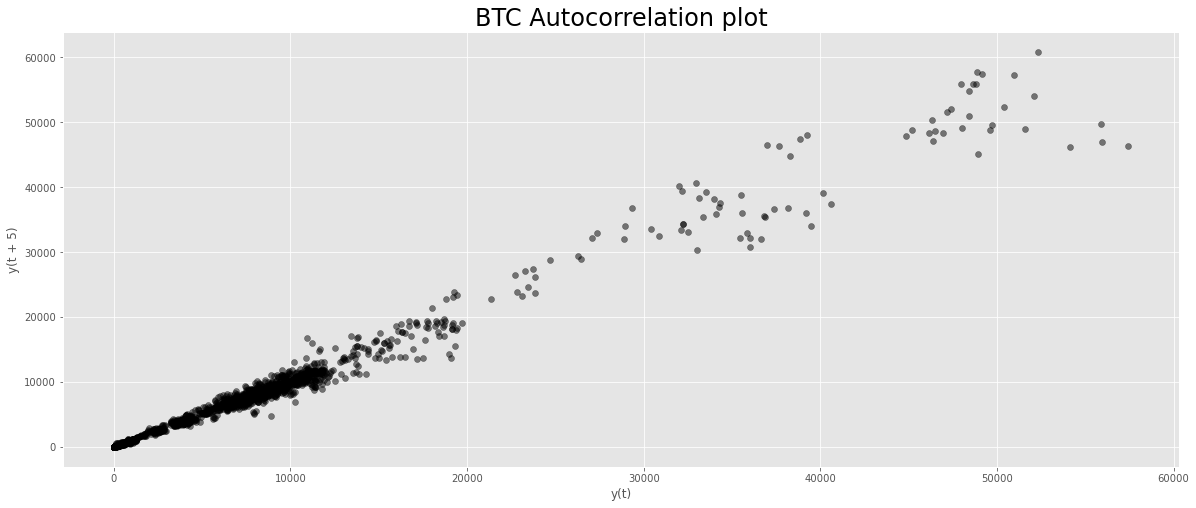

In [3]:
f, ax = plt.subplots(figsize=(20,8))

lag_plot(btc['Close'], lag=5, c = 'black', alpha =.5)
ax.set_title('BTC Autocorrelation plot', fontsize = 24)

In [5]:
btc = btc.drop(columns={'Currency'})

In [6]:
btc_log = btc.apply(np.log)

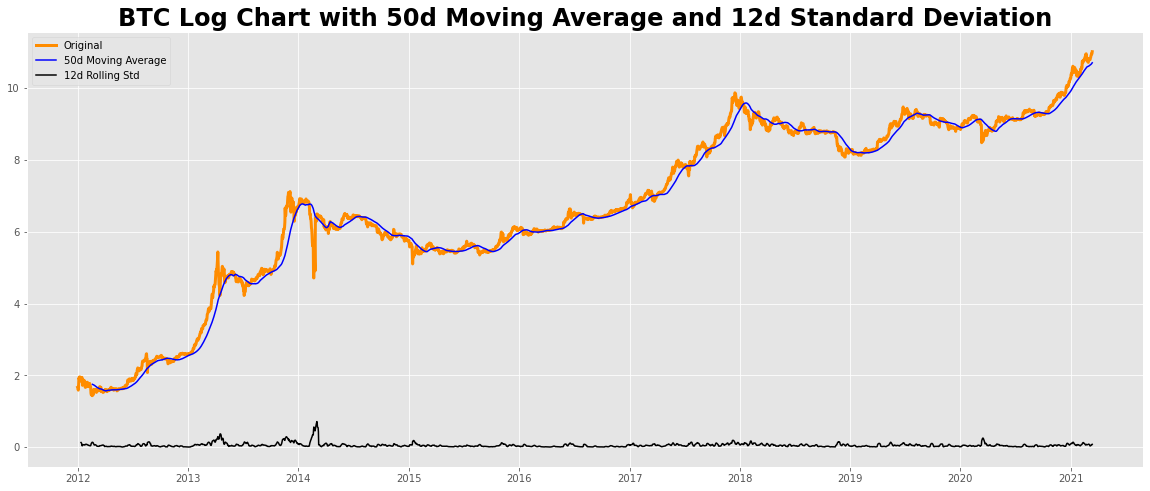

Results of dickey fuller test
Test Statistics                  -1.030783
p-value                           0.741872
No. of lags used                 11.000000
Number of observations used    3348.000000
critical value (1%)              -3.432305
critical value (5%)              -2.862404
critical value (10%)             -2.567230
dtype: float64


In [8]:
#Test for stationarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(50).mean() #50day MA
    rolstd = timeseries.rolling(12).std() #12day rolling Std 
    #Plot rolling statistics:
    plt.figure(figsize=(20,8))
    plt.plot(timeseries, color='darkorange',label='Original', lw=3)
    plt.plot(rolmean, color='blue', label='50d Moving Average')
    plt.plot(rolstd, color='black', label = '12d Rolling Std')
    plt.legend(loc='best')
    plt.title('BTC Log Chart with 50d Moving Average and 12d Standard Deviation', fontsize =24, fontweight='bold')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(btc_log['Close'])

<Figure size 1440x576 with 0 Axes>

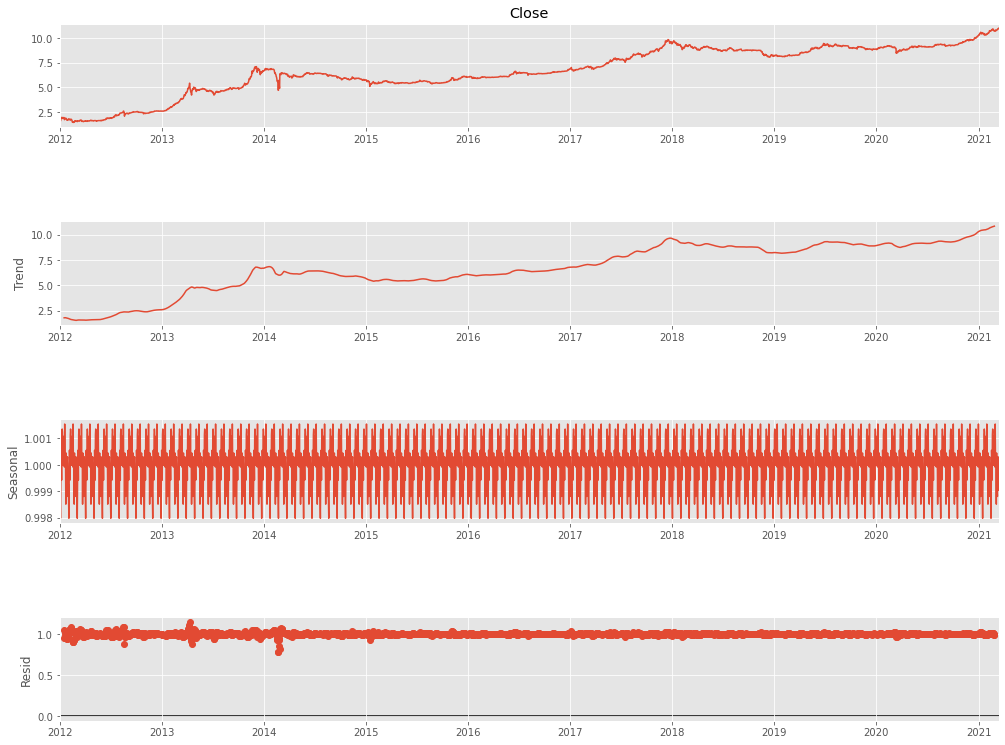

In [9]:
result = seasonal_decompose(btc_log['Close'], model='multiplicative', freq = 30)
fig = plt.figure(figsize=(20,8))  
fig = result.plot()  
fig.set_size_inches(16, 12)

In [10]:
btc_log['Log_Returns'] = btc_log['Close'].pct_change()

Text(0.5, 0, 'Date')

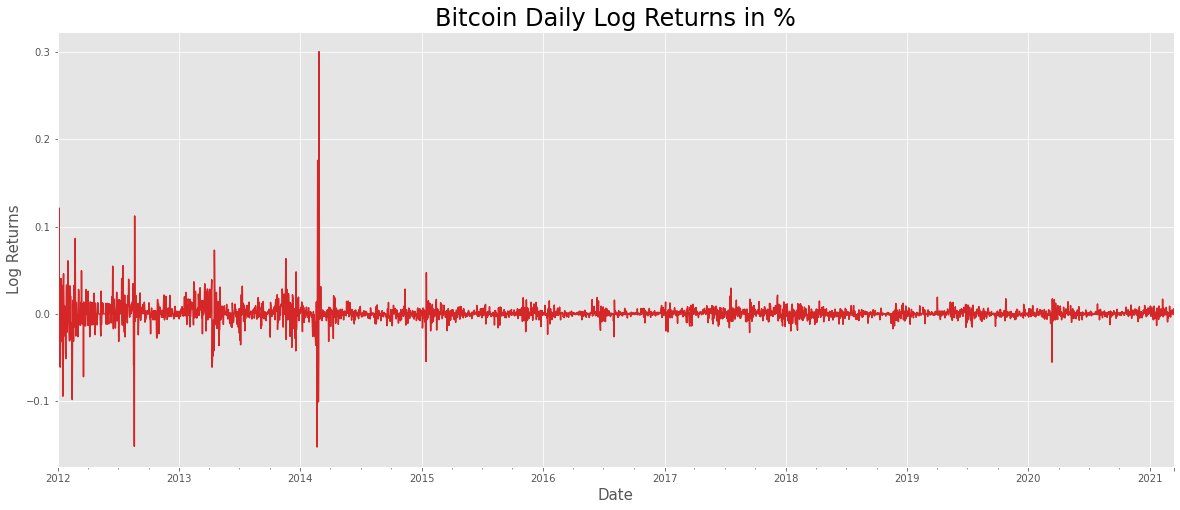

In [12]:
f, ax = plt.subplots(figsize=(20,8))

btc_log['Log_Returns'].plot(color='tab:red')
ax.set_title('Bitcoin Daily Log Returns in %', fontsize = 24)
ax.set_ylabel('Log Returns', fontsize = 15)
ax.set_xlabel('Date', fontsize = 15)

In [13]:
df_log = btc_log.copy()

In [15]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(np.log(btc['Close']))*0.8)], df_log[int(len(np.log(btc['Close']))*0.8):]

Text(0.5, 0, 'Dates')

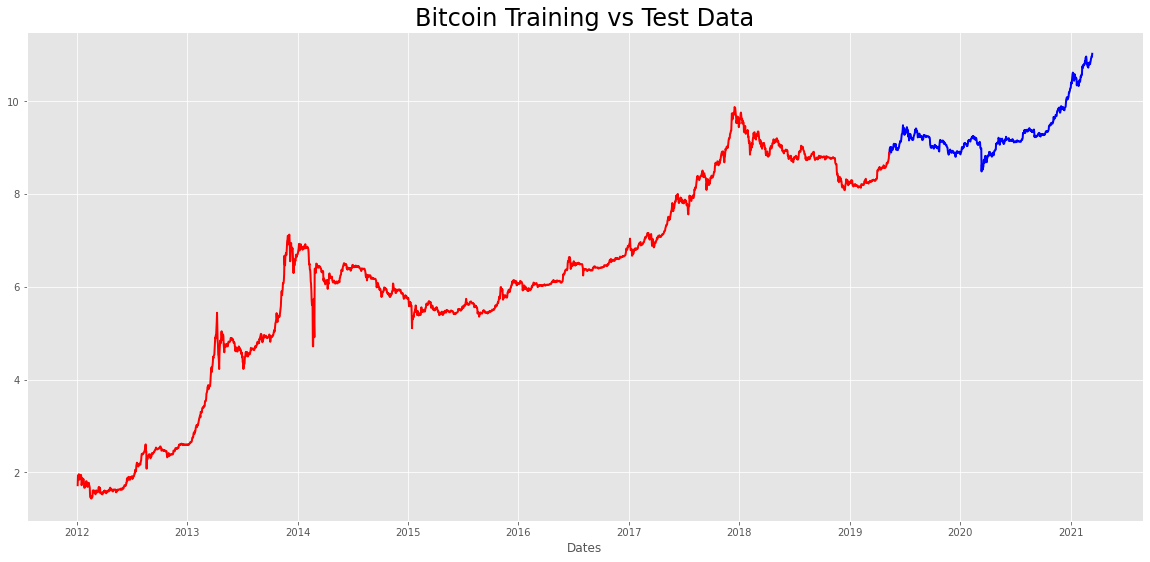

In [16]:
f, ax = plt.subplots(figsize=(20,9))

plt.plot(test_data['Close'], 'blue', label='Test data', lw =2)
plt.plot(train_data['Close'], 'red', label='Training data', lw = 2)
plt.title("Bitcoin Training vs Test Data", fontsize =24)
plt.xlabel('Dates')

In [17]:
training_data = train_data['Close']

In [18]:
model_autoARIMA = auto_arima(training_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find             optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-7448.683, Time=0.94 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-7447.321, Time=1.23 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-7447.826, Time=1.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-7445.450, Time=0.58 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-7475.461, Time=2.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-7577.042, Time=2.23 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-7579.023, Time=1.16 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-7577.071, Time=2.34 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-7575.038, Time=1.88 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=-7573.222, Time=0.29 sec

Best model:  ARIMA(2,1,0)(0,0,0)[0] intercept
Total fit time: 14.081 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2685
Model:               SARIMAX(2, 1, 0)   Log Likelih

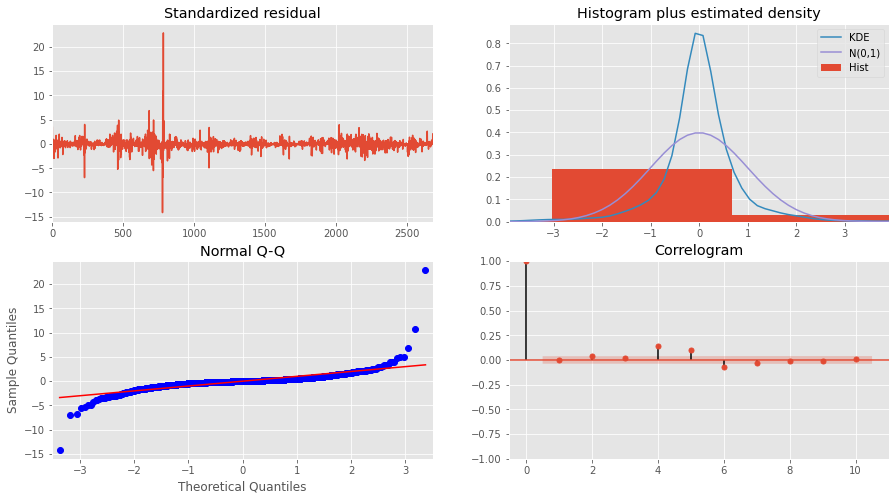

In [19]:
# let’s review the residual plots from auto ARIMA

model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [20]:
# ARIMA model

model = ARIMA(training_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 2684
Model:                 ARIMA(3, 1, 2)   Log Likelihood                3846.344
Method:                       css-mle   S.D. of innovations              0.058
Date:                Sat, 13 Mar 2021   AIC                          -7678.688
Time:                        14:14:01   BIC                          -7637.422
Sample:                    01-05-2012   HQIC                         -7663.760
                         - 05-11-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0027      0.001      2.321      0.020       0.000       0.005
ar.L1.D.Close     0.8465      0.056     15.227      0.000       0.738       0.955
ar.L2.D.Close    -0.7628      0.039    -

In [51]:
# Forecast
fc, se, conf = fitted.forecast(539, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)

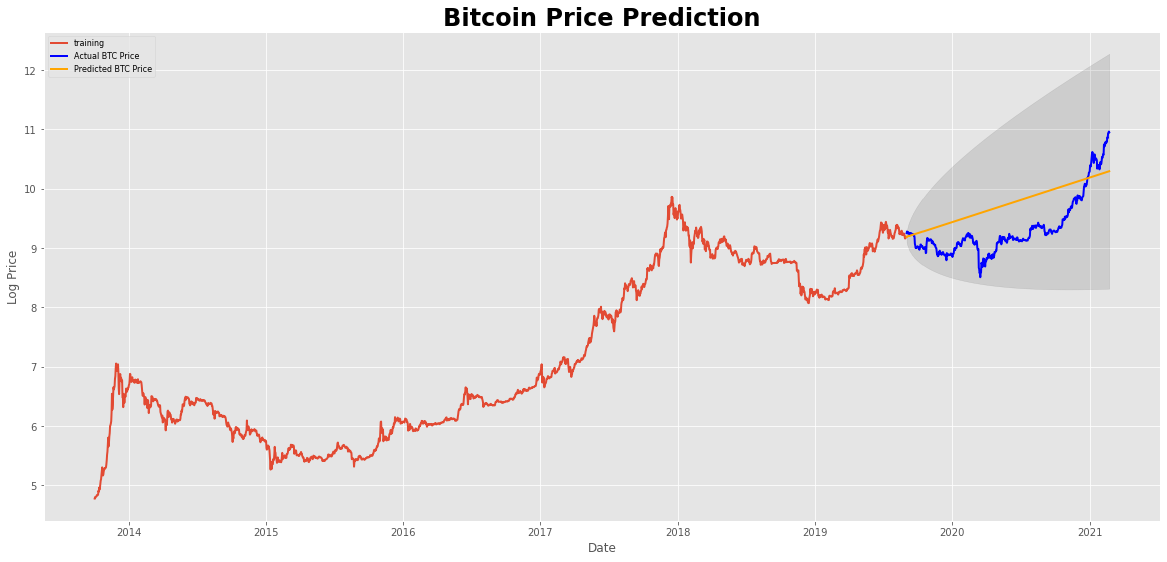

In [55]:
f, ax = plt.subplots(figsize=(20,9))

plt.plot(train_data['Close'], label='training', lw=2)
plt.plot(test_data['Close'], color = 'blue', label='Actual BTC Price', lw=2)
plt.plot(fc_series, color = 'orange',label='Predicted BTC Price', lw=2)
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Bitcoin Price Prediction', fontsize=24, fontweight = 'bold')
plt.xlabel('Date')
plt.ylabel('Log Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()